<a href="https://colab.research.google.com/github/EstebanAG1005/Lab-9-DL/blob/main/lab9task7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
date     0
store    0
item     0
sales    0
dtype: int64
5702/5702 [==============================] - 24s 4ms/step - loss: 0.0015
Loss: 0.001483689877204597
5702/5702 [==============================] - 20s 3ms/step
Mean Squared Error (MSE): 79.17118993934788
Mean Absolute Error (MAE): 6.772353417516356


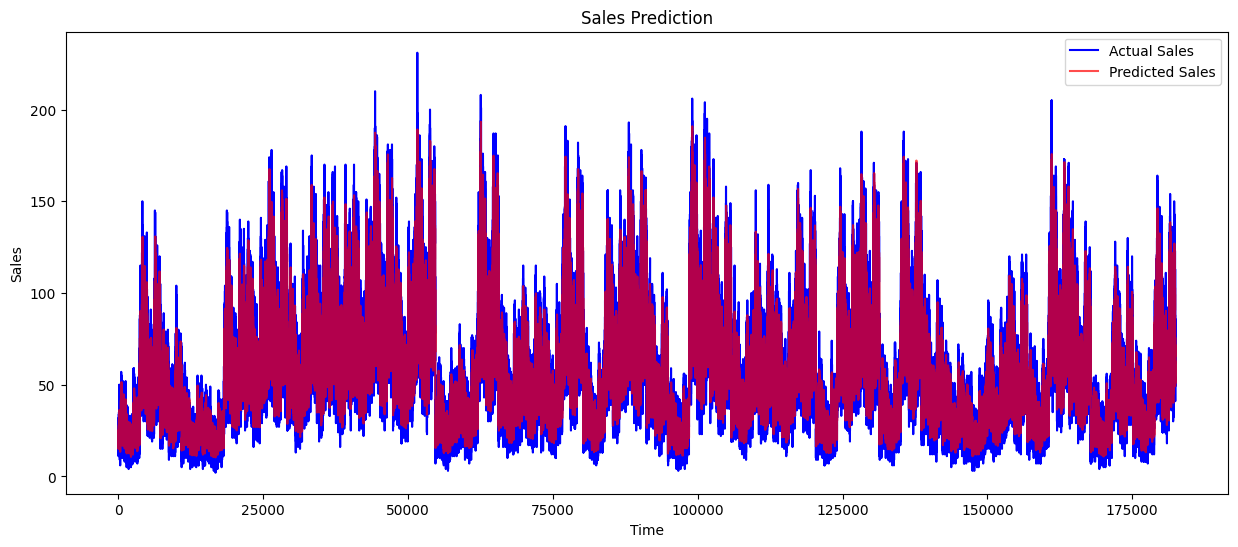

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import os

# Montar Google Drive (si se está ejecutando en Google Colab)
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/train.csv"

data = pd.read_csv(data_path)

# Verificar valores nulos
print(data.isnull().sum())

# Convertir la columna 'date' a datetime
data['date'] = pd.to_datetime(data['date'])

# Escalar la columna 'sales'
scaler = MinMaxScaler(feature_range=(0, 1))
data['sales'] = scaler.fit_transform(data[['sales']])

# Asumiendo que 'data' es tu DataFrame y ya has realizado la limpieza y escalado
train_data = data[data['date'] < '2017-01-01']
test_data = data[data['date'] >= '2017-01-01']

# Asegurarse de que solo estás trabajando con la columna que deseas predecir, en este caso, 'sales'
train_data = train_data[['sales']].values
test_data = test_data[['sales']].values

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana
window_size = 60  # Por ejemplo, usar los 60 puntos de datos anteriores para predecir el siguiente

# Crear secuencias para entrenamiento
X_train, y_train = create_sequences(train_data, window_size)

# Crear secuencias para prueba
X_test, y_test = create_sequences(test_data, window_size)

# Es importante que los datos estén en la forma correcta para alimentar a la LSTM
# Reformar [muestras, pasos de tiempo, características]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Dividir los datos de entrenamiento para crear un conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

def build_model(units_lstm, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=units_lstm, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))  # Salida de una unidad para la predicción de ventas
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Listas de hiperparámetros a probar
units_lstm_list = [50]
dropout_rate_list = [0.6]

# Directorio donde se guardarán los modelos
model_dir = 'model_directory'
os.makedirs(model_dir, exist_ok=True)

best_model = None
best_mse = float('inf')

# Todos los modelos
for units_lstm in units_lstm_list:
    for dropout_rate in dropout_rate_list:
        # Construir y compilar el modelo
        model = build_model(units_lstm, dropout_rate)

        # Entrenar el modelo
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

        # Evaluar el modelo
        loss = model.evaluate(X_test, y_test, verbose=0)

        # Generar un nombre único para el modelo basado en los hiperparámetros
        model_name = f"model_units{units_lstm}_dropout{int(dropout_rate * 10)}.keras"
        model_path = os.path.join(model_dir, model_name)

        # Guardar el modelo con el nombre único
        model.save(model_path)

        # Guardar el mejor modelo si la pérdida es menor
        if loss < best_mse:
            best_mse = loss
            best_model = model

# Cargar el mejor modelo
new_model = best_model

# Evaluar el mejor modelo con datos de prueba
loss = new_model.evaluate(X_test, y_test)
print(f"Loss: {loss}")

# Si deseas hacer predicciones y compararlas con los valores reales
predicted_sales = new_model.predict(X_test)

# 'predicted_sales' son los valores escalados, por lo que podrías querer revertir la transformación
predicted_sales = scaler.inverse_transform(predicted_sales)

# Suponiendo que 'actual_sales' es la parte de 'y_test' que corresponde a las ventas reales
actual_sales = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Calcular y imprimir MSE y MAE
mse = mean_squared_error(actual_sales, predicted_sales)
mae = mean_absolute_error(actual_sales, predicted_sales)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Visualizar los resultados
plt.figure(figsize=(15, 6))

# Dibujar las ventas reales
plt.plot(actual_sales, color='blue', label='Actual Sales')

# Dibujar las ventas predichas
plt.plot(predicted_sales, color='red', alpha=0.7, label='Predicted Sales')

plt.title('Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()